# 准备数据

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import wfdb 
import numpy as np
import math
import sys
import scipy.stats as st
import scipy.io as sio
import scipy
import glob, os
from os.path import basename

import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import Dense,Activation,Dropout,add
from keras.layers import LSTM,Bidirectional #could try TimeDistributed(Dense(...))
from keras.models import Sequential, load_model
from keras import optimizers,regularizers
from keras.layers.normalization import BatchNormalization
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm
from keras.utils import np_utils
from scipy import ndimage
import pandas as pd
import matplotlib.pyplot as plt                    #导入pandas包
from keras.utils import to_categorical
from tqdm import tqdm

from scipy import signal
# from biosppy.signals import ecg
import logging


Using TensorFlow backend.


In [2]:
# from net import build_model
# from keras.layers import Input
# from keras.models import Model

# input_layer = Input((2000, 1))
# output_layer = build_model(input_layer=input_layer,start_neurons=16)
# model3 = Model(input_layer, output_layer)
# model3.summary()

In [3]:
FS_ORI = 400
FS = 200

CONST = FS/FS_ORI
THR = 0.15
DATA_PATH = '../TrainingSet/data/'
REF_PATH = '../TrainingSet/ref/'
ms_150 = 0.12*FS
ms_200 = 0.15*FS
len_seg = FS*10#1024
len_ecg = FS*10#1024

In [4]:
from scipy import ndimage, misc
def med_filt_1d(ecg):
    '''
    first_filtered = ndimage.median_filter(ecg, size=int(0.4*FS))
    second_filtered =  ndimage.median_filter(first_filtered, int(2*FS))
    '''
    first_filtered = ndimage.median_filter(ecg, size=int(7*(FS/FS_ORI)))
    second_filtered =  ndimage.median_filter(first_filtered, int(215*(FS/FS_ORI)))
    ecg_deno = ecg - second_filtered
    return ecg_deno

from scipy.signal import butter, sosfilt, sosfiltfilt, filtfilt
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype="band", output="sos")
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos,data)    
    return y

def butter_bandpass_forward_backward_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos,data) 
    return y

from sklearn import preprocessing as prep

def getSigArr(sig, sigNorm='minmax'):
    if sigNorm == 'scale':
        sig = prep.scale(sig)
    elif sigNorm == 'minmax':
        min_max_scaler = prep.MinMaxScaler()
        sig = min_max_scaler.fit_transform(sig)
    return sig

In [5]:
def reLabel(x, y, label_type = 1):
    '''
    对所有QRS波进行标记，QRS波检测函数采用biosppy工具包中的osea检测方法
    '''
    for ind in range(0,x.shape[0]):
        summary_result = ecg.ecg(x[ind], FS, False)
        
#         x[ind] = butter_bandpass_forward_backward_filter(x[ind], 0.5, 35, FS, order=5)
        x[ind] = med_filt_1d(x[ind])
#         x[ind] = WTfilt_1d(x[ind])
        
        """
        if(ind < 5):
            plt.figure( )
            plt.plot(x[ind])
            plt.plot(summary_result['filtered_selfdef'])
            plt.show()
        """    
        for m in summary_result['rpeaks']:
            label = y[ind][m]
            if label == 0:
                m_begin = int(m-ms_150 if m-ms_150>=0 else 0)
                m_end = int(m+ms_200 if m+ms_200<len_ecg else len_ecg-1)
                
                y[ind][m_begin:m_end] = label_type;
            else:
                pass 
        
    return x,y

In [6]:
data_files = os.listdir(DATA_PATH)
ref_files = glob.glob(REF_PATH + '*.mat')

In [7]:
data_files.sort()
data_files

['A01.mat',
 'A02.mat',
 'A03.mat',
 'A04.mat',
 'A05.mat',
 'A06.mat',
 'A07.mat',
 'A08.mat',
 'A09.mat',
 'A10.mat']

In [8]:
ref_files.sort()
ref_files

['../TrainingSet/ref/R01.mat',
 '../TrainingSet/ref/R02.mat',
 '../TrainingSet/ref/R03.mat',
 '../TrainingSet/ref/R04.mat',
 '../TrainingSet/ref/R05.mat',
 '../TrainingSet/ref/R06.mat',
 '../TrainingSet/ref/R07.mat',
 '../TrainingSet/ref/R08.mat',
 '../TrainingSet/ref/R09.mat',
 '../TrainingSet/ref/R10.mat']

In [9]:
def firstLabel(label_new, label_ref, len_ecg, label_type): 
    '''
    根据早搏位置，对早搏心拍进行标记
    '''
    try:
        for m in label_ref:
            m_begin = int(m-ms_150 if m-ms_150>=0 else 0)
            m_end = int(m+ms_200 if m+ms_200<len_ecg else len_ecg-1)

            for n in range(m_begin,m_end):
                label_new[n] = label_type
                
    except TypeError:
        print("TypeError")
        m_begin = int(label_ref-ms_150 if label_ref-ms_150>=0 else 0)
        m_end = int(label_ref+ms_200 if label_ref+ms_200<len_ecg else len_ecg-1)

        for n in range(m_begin,m_end):
            label_new[n] = label_type
            
        pass
    return


def resave_data(ecg_data, label_new, dataid, is_select = 0):
    '''
    数据分段，段长度为len_seg，
    如果第一秒和最后一秒数据出现早搏，则将数据前移或者后移一秒
    '''
    mod_res = len(ecg_data)%len_seg 
    if (mod_res > 0):
        num_to_pad = len_seg - mod_res
        ecg_data_pad = np.pad(ecg_data,(0,num_to_pad),'constant', constant_values=(0,0)) 
        label_new_pad = np.pad(label_new,(0,num_to_pad),'constant', constant_values=(0,0)) 
    else:
        ecg_data_pad = ecg_data
        label_new_pad = np.array(label_new)
    
    ecg_data_mat = None
    label_new_mat = None
    
    len_ecg_pad = len(ecg_data_pad)

    ind = 0
    while ind < len_ecg_pad:
        ind_begin = ind
        ind_end = ind_begin+len_seg
        
        if ind_end < len_ecg_pad:
            label_tmp_1 = label_new_pad[ind_begin: ind_end]
            
            if ((np.sum(label_tmp_1)) == 0 and is_select):
                ind = ind_begin+len_seg 
                continue
            else:
                if (is_select):
                    if ((np.sum(label_tmp_1[:FS])) >0) :
                        ind_begin = ind - FS
                    elif ((np.sum(label_tmp_1[-FS:]))>0):
                        ind_begin = ind + FS
                    ind_end = ind_begin+len_seg
                
                label_tmp = label_new_pad[ind_begin: ind_end]
                ecg_tmp = ecg_data_pad[ind_begin: ind_end]
                
                if ecg_data_mat is None:
                    ecg_data_mat = np.array(ecg_tmp)
                    label_new_mat = np.array(label_tmp)
                else:
                    ecg_data_mat = np.vstack((ecg_data_mat,ecg_tmp)) 
                    label_new_mat = np.vstack((label_new_mat,label_tmp))   
        else:
            break
            
        ind = ind_begin+len_seg
    """
    scio.savemat("ecgdata_"+FS+"_"dataid+".mat", {'Data':ecg_data_mat, 'Label':label_new_mat})
    plt.figure( )
    plt.plot(ecg_data_mat[2,])
    plt.plot(label_new_mat[2,])
    plt.show()
    """
    return ecg_data_mat, label_new_mat

def load_ans(is_load_train = True, is_select = 0):
    """
    Function for loading the detection results and references
    Input:
        is_load_train：是否加载训练数据
        is_select：是否只加载标签不为零的数据
    Ouput:
        S_refs: position references for S
        V_refs: position references for V
        S_results: position results for S
        V_results: position results for V
    """
    data_files = glob.glob(DATA_PATH + '*.mat')
    ref_files = glob.glob(REF_PATH + '*.mat')
    
    data_files.sort()
    ref_files.sort()
        
    S_refs = []
    V_refs = []
    S_results = []
    V_results = []
    
    data = None
    label = None
    for i, data_file in enumerate(data_files):
        if (is_load_train==1 and (i<7 or i==9)):         #A01~A07以及A10作为训练数据 
            pass
        elif(is_load_train==0 and (i==7 or i==8)):       #A08、A09作为测试数据
            pass
        else:
            continue 
            
        print(data_file)
        
        dataid = data_file.split('/')[-1].split('.')[0]
        print(dataid)
        
        # load ecg file
        ecg_data_ori = sio.loadmat(data_file)['ecg'].squeeze()
        len_ecg_ori = len(ecg_data_ori)

        # 数据下采样
        #ecg_data = signal.resample(ecg_data_ori, int(len_ecg_ori*CONST))
        ecg_data = ecg_data_ori[1::2]
        len_ecg = len(ecg_data)
        
        #数据预处理
        ecg_data = med_filt_1d(ecg_data)
        ##ecg_data = butter_bandpass_forward_backward_filter(ecg_data, 0.5, 35, FS, order=5)
       
        # load answers
        s_ref = sio.loadmat(ref_files[i])['ref']['S_ref'][0, 0].squeeze()
        v_ref = sio.loadmat(ref_files[i])['ref']['V_ref'][0, 0].squeeze()
   
        #标签下采样
        s_ref = (s_ref*CONST).astype(int)
        v_ref = (v_ref*CONST).astype(int)

        label_new = [0]*len_ecg

        #数据标记
        firstLabel(label_new, s_ref, len_ecg, 1)
        firstLabel(label_new, v_ref, len_ecg, 2)
        
        ecg_data_split = []
        ecg_label_split = []
        label_new = np.array(label_new)
        
        for i in tqdm(range(int(ecg_data.shape[0]/len_seg))):
            index_begin = i*len_seg
            index_end = (i+1)*len_seg
            #ecg_seg = ecg_data[i*len_seg:(i+1)*len_seg]
            label_seg = label_new[index_begin:index_end]
            if (label_seg != 0).any() and is_select:
                if (label_seg[:FS] != 0 ).any():
                    index_begin = index_begin - FS
                elif (label_seg[-FS:] != 0 ).any():
                    index_begin = index_begin + FS
                else:
                    pass
                index_end = index_begin + len_seg
                
                ecg_data_split.append(ecg_data[index_begin:index_end].tolist())
                ecg_label_split.append(label_new[index_begin:index_end].tolist())
            elif i%2==0 and is_select:
                ecg_data_split.append(ecg_data[index_begin:index_end].tolist())
                ecg_label_split.append(label_new[index_begin:index_end].tolist())
            elif is_select==0:
                ecg_data_split.append(ecg_data[index_begin:index_end].tolist())
                ecg_label_split.append(label_new[index_begin:index_end].tolist())
            
        ecg_data_split = np.array(ecg_data_split)
        ecg_label_split = np.array(ecg_label_split)
        print("ecg data :",ecg_data_split.shape)
        print("ecg label :",ecg_label_split.shape)
        
#         ecg_data_split = []
        
#         for i in tqdm(range(int(ecg_data.shape[0]/len_seg))):
#             ecg_data_split.append(ecg_data[i*len_seg:(i+1)*len_seg].tolist())
#         ecg_data_split = np.array(ecg_data_split)
        
#         ecg_label_split = []
        
#         label_new = np.array(label_new)
#         for i in tqdm(range(int(label_new.shape[0]/len_seg))):
#             ecg_label_split.append(label_new[i*len_seg:(i+1)*len_seg].tolist())
#         ecg_label_split = np.array(ecg_label_split)

        # 保存分段后数据
        #ecg_data_mat, label_new_mat = resave_data(ecg_data, label_new, dataid, is_select)
        
        if (ecg_data_split.shape[0] >0):
            if data is None:
                data  = ecg_data_split   
                label = ecg_label_split 
            else:
                data  = np.vstack((data, ecg_data_split))
                label = np.vstack((label, ecg_label_split))
    
    try:
        data = getSigArr(data.T).T
    except:
        pass
    
    return data, label

In [10]:
# data_train, label_train = load_ans(True,0)

In [11]:
s_ref = sio.loadmat('../TrainingSet/ref/R02.mat')['ref']['S_ref'][0, 0].squeeze()
v_ref = sio.loadmat('../TrainingSet/ref/R02.mat')['ref']['V_ref'][0, 0].squeeze()
#标签下采样
s_ref = (s_ref*CONST).astype(int)
v_ref = (v_ref*CONST).astype(int)

In [12]:
v_ref

array([     327,      492,      811, ..., 16405079, 16411794, 16417841])

In [13]:
s_ref

array([  703483,   730236,   761800,   767713,   768061,   847109,
         899529,  1288823,  1352921,  1427801,  1438165,  1536301,
        1650469, 15422981, 16146726])

In [14]:
(v_ref/len_seg).astype(int)[-50:]

array([8095, 8096, 8098, 8099, 8100, 8104, 8104, 8114, 8115, 8118, 8118,
       8119, 8121, 8122, 8124, 8125, 8125, 8127, 8129, 8130, 8130, 8132,
       8136, 8141, 8145, 8146, 8146, 8147, 8149, 8150, 8151, 8153, 8155,
       8156, 8161, 8161, 8161, 8162, 8164, 8166, 8168, 8169, 8169, 8194,
       8194, 8196, 8199, 8202, 8205, 8208])

## 加载训练数据

In [15]:
data_train, label_train = load_ans(is_load_train = 1, is_select = 1)

../TrainingSet/data/A01.mat
A01


100%|██████████| 9318/9318 [00:00<00:00, 24209.00it/s]


ecg data : (4674, 2000)
ecg label : (4674, 2000)
../TrainingSet/data/A02.mat
A02


100%|██████████| 8218/8218 [00:00<00:00, 16248.10it/s]


ecg data : (5541, 2000)
ecg label : (5541, 2000)
../TrainingSet/data/A03.mat
A03


100%|██████████| 8892/8892 [00:00<00:00, 24080.68it/s]


ecg data : (4674, 2000)
ecg label : (4674, 2000)
../TrainingSet/data/A04.mat
A04


100%|██████████| 8825/8825 [00:00<00:00, 13013.67it/s]


ecg data : (8057, 2000)
ecg label : (8057, 2000)
../TrainingSet/data/A05.mat
A05


 34%|███▍      | 2865/8486 [00:00<00:00, 28641.90it/s]

TypeError


100%|██████████| 8486/8486 [00:00<00:00, 22491.23it/s]


ecg data : (4251, 2000)
ecg label : (4251, 2000)
../TrainingSet/data/A06.mat
A06


100%|██████████| 8851/8851 [00:00<00:00, 22301.51it/s]


ecg data : (4431, 2000)
ecg label : (4431, 2000)
../TrainingSet/data/A07.mat
A07


100%|██████████| 8319/8319 [00:00<00:00, 15249.32it/s]


ecg data : (7059, 2000)
ecg label : (7059, 2000)
../TrainingSet/data/A10.mat
A10


100%|██████████| 8511/8511 [00:00<00:00, 14654.32it/s]


ecg data : (6373, 2000)
ecg label : (6373, 2000)


In [16]:
data_train.shape,label_train.shape

((45060, 2000), (45060, 2000))

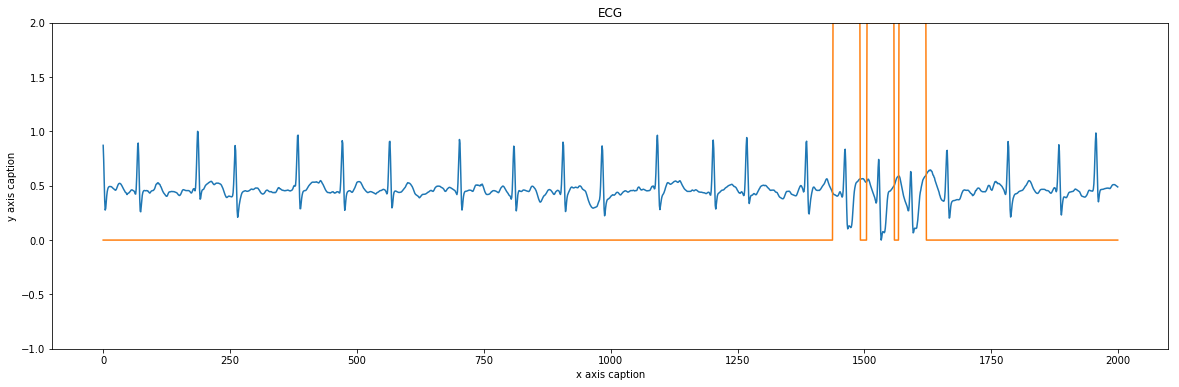

In [17]:
from matplotlib import pyplot as plt 
import wfdb.processing as wp
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 6.0) # 设置figure_size尺寸
plt.rcParams['image.interpolation'] = 'nearest' # 设置 interpolation style

plt.title("ECG") 
plt.xlabel("x axis caption") 
plt.ylabel("y axis caption") 
# plt.scatter(qrs_inds, ecg[qrs_inds], marker='o', c='g',s=50)
# plt.scatter(ecg_ref,  ecg[ecg_ref]+1, marker='^', c='r',s=50)
plt.plot(data_train[6071]) 
plt.plot(label_train[6071]) 
plt.ylim(-1,2)
plt.show()

In [18]:
data_test, label_test = load_ans(False,0)

../TrainingSet/data/A08.mat
A08


100%|██████████| 9166/9166 [00:00<00:00, 12884.42it/s]


ecg data : (9166, 2000)
ecg label : (9166, 2000)
../TrainingSet/data/A09.mat
A09


100%|██████████| 9302/9302 [00:00<00:00, 13995.19it/s]


ecg data : (9302, 2000)
ecg label : (9302, 2000)


In [19]:
label_test.shape

(18468, 2000)

In [20]:
x_test = np.expand_dims(data_test, axis=2)
y_test = np.expand_dims(label_test, axis=2)

In [21]:
# x, y = data_train, label_train
x_train = np.expand_dims(data_train, axis=2)
y_train = np.expand_dims(label_train, axis=2)
np.where(y_train==np.array([2]))

(array([ 4674,  4674,  4674, ..., 44971, 44971, 44971]),
 array([ 303,  304,  305, ..., 1338, 1339, 1340]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [22]:
x_train.shape

(45060, 2000, 1)

In [23]:
# np.save("train_data_bandpass_norm_200.npy", x_train)
# np.save("train_target_bandpass_norm_200.npy", y_train)

## 加载测试数据

In [24]:
# data_test, label_test = load_ans(is_load_train = 0, is_select = 0)

In [25]:
# label_test_tmp = np.sum(label_test, axis = 1)
# ind_test = np.nonzero(label_test_tmp)

In [26]:
# #x, y = reLabel(data_test[ind_test], label_test[ind_test], 1)     //对所有QRS波进行标记
# x, y = data_test[ind_test], label_test[ind_test]            

In [27]:
# x, y = data_test, label_test
# x_test = np.expand_dims(x, axis=2)
# y_test = np.expand_dims(y, axis=2)

In [28]:
# np.save("test_data_bandpass_norm_200.npy", x_test)
# np.save("test_target_bandpass_norm_200.npy", y_test)

# 加载数据

In [29]:
# x_train_ori = np.load("train_data_ori_norm_200.npy")
# y_train_ori = np.load("train_target_ori_norm_200.npy")

In [30]:
# x_test_ori = np.load("test_data_ori_norm_200.npy")
# y_test_ori = np.load("test_target_ori_norm_200.npy")

In [31]:
# x_train_median = np.load("train_data_median_norm_200.npy")
# y_train_median = np.load("train_target_median_norm_200.npy")

In [32]:
# x_test_median = np.load("test_data_median_norm_200.npy")
# y_test_median = np.load("test_target_median_norm_200.npy")

In [33]:
# x_train =  np.vstack((x_train_ori, x_train_median))
# y_train =  np.vstack((y_train_ori, y_train_median))

In [34]:
# x_test =  np.vstack((x_test_ori, x_test_median))
# y_test =  np.vstack((y_test_ori, y_test_median))

In [35]:
#1010
# x_train =  x_train_median
# y_train =  y_train_median

In [36]:
#1010
# x_test = x_test_median
# y_test = y_test_median

In [37]:
nClasses = 3
target_train = y_train

In [38]:
target_train = to_categorical(y_train, num_classes=nClasses)
# target_test = to_categorical(y_test, num_classes=nClasses)

In [39]:
m=np.argmax(target_train, axis = 2)   

In [40]:
m.shape

(45060, 2000)

<function matplotlib.pyplot.show(*args, **kw)>

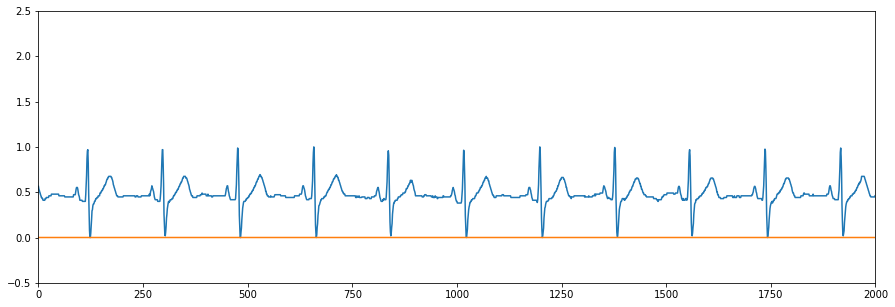

In [41]:
ind = 1986

plt.figure(figsize=(15,5))
plt.plot(x_train[ind])
# plt.plot(y_train[ind])
plt.plot(m[ind])
plt.xlim(0,len_seg)
plt.ylim(-0.5,2.5)
plt.show

# 开始训练

In [42]:
def get_session(gpu_fraction=0.8):
    #allocate % of gpu memory.
    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
    if num_threads:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [43]:
from keras import backend as K
def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1(y_true, y_pred):
    precisionVal = precision(y_true, y_pred)
    recallVal = recall(y_true, y_pred)
    return 2*((precisionVal*recallVal)/(precisionVal+recallVal+K.epsilon()))

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [44]:
#写一个LossHistory类，保存loss和acc  
class LossHistory(keras.callbacks.Callback):  
    def on_train_begin(self, logs={}):  
        self.losses = {'batch':[], 'epoch':[]}  
        self.accuracy = {'batch':[], 'epoch':[]}  
        self.val_loss = {'batch':[], 'epoch':[]}  
        self.val_acc = {'batch':[], 'epoch':[]}  

    def on_batch_end(self, batch, logs={}):  
        self.losses['batch'].append(logs.get('loss'))  
        self.accuracy['batch'].append(logs.get('acc'))  
        self.val_loss['batch'].append(logs.get('val_loss'))  
        self.val_acc['batch'].append(logs.get('val_acc'))  

    def on_epoch_end(self, batch, logs={}):  
        self.losses['epoch'].append(logs.get('loss'))  
        self.accuracy['epoch'].append(logs.get('acc'))  
        self.val_loss['epoch'].append(logs.get('val_loss'))  
        self.val_acc['epoch'].append(logs.get('val_acc'))  

    def loss_plot(self, loss_type):  
        iters = range(len(self.losses[loss_type]))  
        plt.figure()  
        # acc  
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')  
        # loss  
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')  
        if loss_type == 'epoch':  
            # val_acc  
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')  
#             val_loss  
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')  
        plt.grid(True)  
        plt.xlabel(loss_type)  
        plt.ylabel('acc-loss')  
        plt.legend(loc="upper right")  
        plt.show()  

In [45]:
from keras.models import Model
from keras.layers import Input, core, Dropout, concatenate, CuDNNGRU
from keras.layers.convolutional import Conv1D, MaxPooling1D, UpSampling1D
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras_radam import RAdam
from keras.models import Model
from keras.layers import Input, core, Dropout, concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D, UpSampling1D
from keras.optimizers import RMSprop
from keras.optimizers import Adam

## Attention_unet

## resnext Unet

In [46]:
from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add,core
from keras.layers.convolutional import Conv1D, MaxPooling1D, UpSampling1D, AveragePooling1D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.core import Dense, Lambda
from keras.layers.core import Activation
from keras.layers import Input
from keras.layers.merge import concatenate, add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import keras.backend as K
from keras.layers import LeakyReLU
ACTIVATION = "relu"
def __grouped_convolution_block(blockInput, grouped_channels, cardinality, strides, weight_decay=5e-4):
    ''' Adds a grouped convolution block. It is an equivalent block from the paper
    Args:
        input: input tensor
        grouped_channels: grouped number of filters
        cardinality: cardinality factor describing the number of groups
        strides: performs strided convolution for downscaling if > 1
        weight_decay: weight decay term
    Returns: a keras tensor
    '''
    init = blockInput
    group_list = []
    
    if cardinality == 1:
        # with cardinality 1, it is a standard convolution
        x = Conv1D(grouped_channels, 16, padding='same', use_bias=False, strides=(strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    for c in range(cardinality):
#         x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels]
#         if K.image_data_format() == 'channels_last' else
#         lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :, :])(input)
        x =  Lambda(lambda z: z[:, :, c * grouped_channels:(c + 1) * grouped_channels])(blockInput)
    
        x = Conv1D(grouped_channels, 16, padding='same', use_bias=False, strides=(strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

        group_list.append(x)

    group_merge = concatenate(group_list)#axis=channel_axis
    x = BatchNormalization()(group_merge)
    x = Activation('relu')(x)

    return x

def resnext_bottleneck_block(blockInput, filters=64, cardinality=8, strides=1, weight_decay=5e-4):
    ''' Adds a bottleneck block
    Args:
        input: input tensor
        filters: number of output filters
        cardinality: cardinality factor described number of
            grouped convolutions
        strides: performs strided convolution for downsampling if > 1
        weight_decay: weight decay factor
    Returns: a keras tensor
    '''
    init = blockInput

    grouped_channels = int(filters / cardinality)
#     channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

#     # Check if input number of filters is same as 16 * k, else create convolution2d for this input
#     if K.image_data_format() == 'channels_first':
#         if init._keras_shape[1] != 2 * filters:
#             init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
#                           use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
#             init = BatchNormalization(axis=channel_axis)(init)
#     else:
#         if init._keras_shape[-1] != 2 * filters:
#             init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
#                           use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
#             init = BatchNormalization(axis=channel_axis)(init)

    init = Conv1D(filters * 2, 1, padding='same', strides=(strides),
                  use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
    init = BatchNormalization()(init)
    
    x = Conv1D(filters, 1, padding='same', use_bias=False,
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(blockInput)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = __grouped_convolution_block(x, grouped_channels, cardinality, strides, weight_decay)

    x = Conv1D(filters * 2, 1, padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)

    x = add([init, x])
    x = Activation('relu')(x)

    return x

def convolution_block(x, filters, filter_size, strides=1, padding='same', activation=True):
    x = Conv1D(filters, filter_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = Activation(ACTIVATION)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = Activation(ACTIVATION)(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, 16 )
    x = convolution_block(x, num_filters, 16, activation=False)
    x = Add()([x, blockInput])
    return x

def bottleneck(blockInput, num_filters=16, block="resnet"):
    if block == "resnet":
        conv = residual_block(blockInput,num_filters)
        conv = residual_block(blockInput,num_filters)
    elif block == "resnext":
        conv = resnext_bottleneck_block(blockInput,num_filters)
    return conv

def headneck(blockInput, num_neurons=2, block="resnet"):
    conv = []
    conv.append(Conv1D(num_neurons, 3, activation=None, padding="same")(blockInput))
    conv.append(Conv1D(num_neurons, 5, activation=None, padding="same")(blockInput))
    conv.append(Conv1D(num_neurons, 7, activation=None, padding="same")(blockInput))
    conv.append(Conv1D(num_neurons, 11, activation=None, padding="same")(blockInput))
    conv.append(Conv1D(num_neurons, 15, activation=None, padding="same")(blockInput))
    con_conv = concatenate(conv)
    
    return con_conv

# Build model
def build_model(input_layer, start_neurons, block="resnet", DropoutRatio = 0.5,filter_size=32, nClasses=2):
    # 101 -> 50
    conv1 = Conv1D(start_neurons * 1, filter_size, activation=None, padding="same")(input_layer)
    
    conv1 = bottleneck(conv1,start_neurons * 1, block)
    
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling1D((2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv1D(start_neurons * 2, filter_size, activation=None, padding="same")(pool1)
    
    conv2 = bottleneck(conv2,start_neurons * 2, block)
    
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling1D((2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv1D(start_neurons * 4, filter_size, activation=None, padding="same")(pool2)

    conv3 = bottleneck(conv3,start_neurons * 4, block)
    
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling1D((2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv1D(start_neurons * 8, filter_size, activation=None, padding="same")(pool3)
#     conv4 = residual_block(conv4,start_neurons * 8)
#     conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = bottleneck(conv4,start_neurons * 8, block)
    
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling1D((2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv1D(start_neurons * 16, filter_size, activation=None, padding="same")(pool4)
#     convm = residual_block(convm,start_neurons * 16)
#     convm = residual_block(convm,start_neurons * 16)
    convm = bottleneck(convm,start_neurons * 16, block)
    
    convm = Activation(ACTIVATION)(convm)
    
    # 6 -> 12
    #deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4 = Conv1D(start_neurons * 8, filter_size,activation='relu', padding='same'
                     )(UpSampling1D(size=2)(convm))#kernel_initializer='he_normal'
    
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv1D(start_neurons * 8, filter_size, activation=None, padding="same")(uconv4)
#     uconv4 = residual_block(uconv4,start_neurons * 8)
#     uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = bottleneck(uconv4,start_neurons * 8, block)
    
    uconv4 = Activation(ACTIVATION)(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    deconv3 = Conv1D(start_neurons * 4, filter_size, activation='relu', padding='same',
                     )(UpSampling1D(size=2)(uconv4))#kernel_initializer='he_normal'
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv1D(start_neurons * 4, filter_size, activation=None, padding="same")(uconv3)
#     uconv3 = residual_block(uconv3,start_neurons * 4)
#     uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = bottleneck(uconv3,start_neurons * 4, block)

    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    #deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2 = Conv1D(start_neurons * 2, filter_size, activation='relu', padding='same',
                     )(UpSampling1D(size=2)(uconv3))#kernel_initializer='he_normal'
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv1D(start_neurons * 2, filter_size, activation=None, padding="same")(uconv2)
#     uconv2 = residual_block(uconv2,start_neurons * 2)
#     uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = bottleneck(uconv2,start_neurons * 2, block)

    uconv2 = Activation(ACTIVATION)(uconv2)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    deconv1 = Conv1D(start_neurons * 1, filter_size, activation='relu', padding='same',
                     )(UpSampling1D(size=2)(uconv2))#kernel_initializer='he_normal'
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv1D(start_neurons * 1, filter_size, activation=None, padding="same")(uconv1)
#     uconv1 = residual_block(uconv1,start_neurons * 1)
#     uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = bottleneck(uconv1,start_neurons * 1, block)
    
    uconv1 = Activation(ACTIVATION)(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv1D(1, 1, padding="same", activation="sigmoid")(uconv1)
    output_layer = Conv1D(nClasses, 1, activation='relu', padding='same')(uconv1)#kernel_initializer='he_normal'
    #output_layer = core.Reshape((nClasses, input_length))(output_layer)
    #output_layer = core.Permute((2, 1))(output_layer)
    output_layer = core.Activation('softmax')(output_layer)
    #model = Model(inputs=inputs, outputs=conv9)
    
    return output_layer

## Unet

In [47]:
# Unet
def Unet(nClasses, optimizer=None, input_length=len_ecg, nChannels=1):
    inputs = Input((input_length, nChannels))

    conv1 = Conv1D(16, 32, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv1D(16, 32, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(32, 32, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv1D(32, 32, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    
    conv3 = Conv1D(64, 32, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv1D(64, 32, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    conv4 = Conv1D(128, 32, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Dropout(0.5)(conv4)
    conv4 = Conv1D(128, 32, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)

    up1 = Conv1D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling1D(size=2)(conv4))
    merge1 = concatenate([up1, conv3], axis=-1)
    conv5 = Conv1D(64, 32, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv5 = Conv1D(64, 32, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    
    up2 = Conv1D(32, 2, activation='relu', padding='same', kernel_initializer = 'he_normal')(UpSampling1D(size=2)(conv5))
    merge2 = concatenate([up2, conv2], axis=-1)
    conv6 = Conv1D(32, 32, activation='relu', padding='same', kernel_initializer = 'he_normal')(merge2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv1D(32, 32, activation='relu', padding='same')(conv6)
    
    up3 = Conv1D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling1D(size=2)(conv6))
    merge3 = concatenate([up3, conv1], axis=-1)
    conv7 = Conv1D(16, 32, activation='relu', padding='same', kernel_initializer='he_normal')(merge3)
    conv7 = Conv1D(16, 32, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    x = Bidirectional(CuDNNGRU(32,return_sequences=True))(conv7)
    x = Dropout(0.2)(x)

    conv9 = Conv1D(1, 1, activation='sigmoid', kernel_initializer = 'he_normal', padding='same')(x)

    model = Model(inputs=inputs, outputs=conv9)

    return model

## NestUnet

In [48]:
# NestUnet
from keras.layers import LeakyReLU
deep_supervision = 0
debug = 0

nb_filter = [16,32,64,128,256]

act = "relu"

def cov_layer(x, filter_num, dropout,filter_size = 32, batch_norm=True):
    conv = Conv1D(filter_num, filter_size, padding='same', kernel_initializer='he_normal')(x)
    
    if batch_norm:
        conv = BatchNormalization()(conv)
        
    conv = Activation(act)(conv)    
    conv = Dropout(dropout)(conv)
        
    conv = Conv1D(filter_num, filter_size, padding='same', kernel_initializer='he_normal')(conv)
    
    if batch_norm:
        conv = BatchNormalization()(conv)
        
    conv = Activation(act)(conv)    
    conv = Dropout(dropout)(conv)
    
    res_conv = conv
    return res_conv

def NestUnet(nClasses, optimizer=None, input_length=len_ecg, filter_size = 32, nChannels=1):
    
    inputs = Input((input_length, nChannels))
    
    conv1_1 = cov_layer(inputs, nb_filter[0], 0)
    pool1 = MaxPooling1D(pool_size=2)(conv1_1)
    
    conv2_1 = cov_layer(pool1, nb_filter[1], 0.2)
    pool2 = MaxPooling1D(pool_size=2)(conv2_1)
    
    up1_2 = Conv1D(nb_filter[0], filter_size, padding='same')(UpSampling1D(size=2)(conv2_1))
    conv1_2 = concatenate([up1_2, conv1_1], axis=-1)
    conv1_2 = cov_layer(conv1_2, nb_filter[0], 0)
    
    conv3_1 = cov_layer(pool2, nb_filter[2], 0)
    pool3 = MaxPooling1D(pool_size=2)(conv3_1)

    up2_2 = Conv1D(nb_filter[1], filter_size, padding='same')(UpSampling1D(size=2)(conv3_1))
    conv2_2 = concatenate([up2_2, conv2_1], axis=-1)
    conv2_2 = cov_layer(conv2_2, nb_filter[1], 0.2)
    
    up1_3 = Conv1D(nb_filter[0], filter_size, padding='same')(UpSampling1D(size=2)(conv2_2))
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], axis=-1)
    conv1_3 = cov_layer(conv1_3, nb_filter[0], 0)
    
    conv4_1 = cov_layer(pool3, nb_filter[3], 0)
    pool4 = MaxPooling1D(pool_size=2)(conv4_1)
    
    up3_2 = Conv1D(nb_filter[2], filter_size, padding='same')(UpSampling1D(size=2)(conv4_1))
    conv3_2 = concatenate([up3_2, conv3_1], axis=-1)
    conv3_2 = cov_layer(conv3_2, nb_filter[2], 0)
    
    up2_3 = Conv1D(nb_filter[1], filter_size, padding='same')(UpSampling1D(size=2)(conv3_2))
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], axis=-1)
    conv2_3 = cov_layer(conv2_3, nb_filter[1], 0.2)
    
    up1_4 = Conv1D(nb_filter[0], filter_size, padding='same')(UpSampling1D(size=2)(conv2_3))
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], axis=-1)
    conv1_4 = cov_layer(conv1_4, nb_filter[0], 0)
    
    conv5_1 = cov_layer(pool4, nb_filter[4], 0)               #20200417修改：nb_filter[3]
    
    up4_2 = Conv1D(nb_filter[3], filter_size, padding='same')(UpSampling1D(size=2)(conv5_1))
    conv4_2 = concatenate([up4_2, conv4_1], axis=-1)
    conv4_2 = cov_layer(conv4_2, nb_filter[3], 0)
    
    up3_3 = Conv1D(nb_filter[2], filter_size, padding='same')(UpSampling1D(size=2)(conv4_2))
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], axis=-1)
    conv3_3 = cov_layer(conv3_3, nb_filter[2], 0.2)
    
    up2_4 = Conv1D(nb_filter[1], filter_size, padding='same')(UpSampling1D(size=2)(conv3_3))
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], axis=-1)
    conv2_4 = cov_layer(conv2_4, nb_filter[1], 0)
    
    up1_5 = Conv1D(nb_filter[0], filter_size, padding='same')(UpSampling1D(size=2)(conv2_4))
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], axis=-1)
    conv1_5 = cov_layer(conv1_5, nb_filter[0], 0)
    
#     x = Bidirectional(CuDNNGRU(32,return_sequences=True))(conv1_5)
#     x = Dropout(0.2)(x)
  
    if deep_supervision:
        nestnet_output_1 = Conv1D(1, 1, activation='sigmoid', kernel_initializer = 'he_normal', padding='same')(conv1_2)
        nestnet_output_2 = Conv1D(1, 1, activation='sigmoid', kernel_initializer = 'he_normal', padding='same')(conv1_3)
        nestnet_output_3 = Conv1D(1, 1, activation='sigmoid', kernel_initializer = 'he_normal', padding='same')(conv1_4)
        nestnet_output_4 = Conv1D(1, 1, activation='sigmoid', kernel_initializer = 'he_normal', padding='same')(conv1_5)
    
        model = Model(input=inputs, output=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:    
#         nestnet_output = Conv1D(1, 1, activation='sigmoid', kernel_initializer = 'he_normal', padding='same')(conv1_5)
#         model = Model(input=inputs, output=nestnet_output)
        
        conv6 = Conv1D(nClasses, 1, activation='relu', kernel_initializer = 'he_normal', padding='same')(conv1_5)
        #conv6 = core.Reshape((nClasses, input_length))(conv6)
        #conv6 = core.Permute((2, 1))(conv6)
        
        nestnet_output = core.Activation('softmax')(conv6)  #sigmoid
        
        model = Model(input=inputs, output=nestnet_output)
        
    return model
# model = NestUnet(3)
# model.summary()

In [49]:
# Custom loss function
# def dice_coef(y_true, y_pred):
#     smooth = 1.
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
    
# #     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

# def dice_coef_loss(y_true, y_pred):
#     return 1. - dice_coef(y_true, y_pred)

# def bce_dice_loss(y_true, y_pred):
#     return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def dice_coef_loss(y_true, y_pred):
    axis_to_reduce = [1,2]#range(1, K.ndim(y_pred))  # Reduce all axis but first (batch)
    numerator = y_true * y_pred #* class_weights  # Broadcasting
    numerator = 2. * K.sum(numerator, axis=axis_to_reduce)

    denominator = (y_true + y_pred) #* class_weights # Broadcasting
    denominator = K.sum(denominator, axis=axis_to_reduce)

    return 1 - numerator / denominator

def ce_dice_loss(y_true, y_pred):
    return  keras.losses.categorical_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

In [50]:
epsilon = 1e-5
smooth = 1
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    
    return K.pow((1-pt_1), gamma)

In [51]:
from keras import backend as K
'''
Compatible with tensorflow backend
'''
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [52]:
from keras.losses import categorical_crossentropy
 
def generalized_dice(y_true, y_pred):
    
    """
    Generalized Dice Score
    https://arxiv.org/pdf/1707.03237
    
    """
    y_true    = K.reshape(y_true,shape=(-1,4))
    y_pred    = K.reshape(y_pred,shape=(-1,4))
    sum_p     = K.sum(y_pred, -2)
    sum_r     = K.sum(y_true, -2)
    sum_pr    = K.sum(y_true * y_pred, -2)
    weights   = K.pow(K.square(sum_r) + K.epsilon(), -1)
    generalized_dice = (2 * K.sum(weights * sum_pr)) / (K.sum(weights * (sum_r + sum_p)))
    
    return generalized_dice
 
def generalized_dice_loss(y_true, y_pred):   
    return 1-generalized_dice(y_true, y_pred)
    
    
def custom_loss(y_true, y_pred):
    
    """
    The final loss function consists of the summation of two losses "GDL" and "CE"
    with a regularization term.
    """
    
    return generalized_dice_loss(y_true, y_pred) + 1.25 * categorical_crossentropy(y_true, y_pred)

In [53]:
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [54]:
def scheduler1(epoch):
    lr = 0.01
    if epoch >= 20 and epoch < 40:
        lr = 0.001
    if epoch >= 40:
        lr = 0.0001
    print('Learning rate: ', lr)
    return lr

# def scheduler2(epoch):
#     # 每隔10个epoch，学习率减小为原来的1/10     if epoch % 10 == 0 and epoch != 0:
#         lr = K.get_value(model.optimizer.lr)
#         K.set_value(model.optimizer.lr, lr * 0.1)
#         print("lr changed to {}".format(lr * 0.1))
#     return K.get_value(model.optimizer.lr)

def scheduler3(epoch):
    # 训练网络时学习率衰减方案
    lr = 0.0001
    if epoch >= 50:
        lr = 0.00001
    print('Learning rate: ', lr)
    return lr_schedule


In [55]:
import time
import shutil
time_ori = time.strftime('%Y-%m-%d %X').split(" ")[0]
def save_epoch(epoch, types):
    if ((epoch%10==0)):   
        shutil.copyfile('{}_deepsupervision_model_weights_{}.h5'.format(types, time_ori),
                        '{}_deepsupervision_model_weights_{}_epoch{}.h5'.format(types,time_ori,epoch))

In [56]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0'   #指定第一块GPU可用
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8  # 程序最多只能占用指定gpu50%的显存
config.gpu_options.allow_growth = True      #程序按需申请内存
sess = tf.Session(config = config)
# 设置session
KTF.set_session(sess)




Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Train on 40554 samples, validate on 4506 samples
Epoch 1/10
 - 139s - loss: 0.7081 - acc: 0.9023 - auc: 0.8117 - f1: 0.7359 - val_loss: 0.5364 - val_acc: 0.9830 - val_auc: 0.9532 - val_f1: 0.9559

Epoch 00001: val_loss improved from inf to 0.53644, saving model to unetplus_deepsupervision_model_weights_2020-10-19.h5
Epoch 2/10
 - 122s - loss: 0.4826 - acc: 0.9936 - auc: 0.9735 - f1: 0.9767 - val_loss: 0.3994 - val_acc: 0.9918 - val_auc: 0.9843 - val_f1: 0.9899

Epoch 00002: val_loss improved from 0.53644 to 0.39939, saving model to unetplus_deepsupervision_model_weights_2020-10-19.h5
Epoch 3/10
 - 122s - loss: 0.3646 - acc: 0.9960 

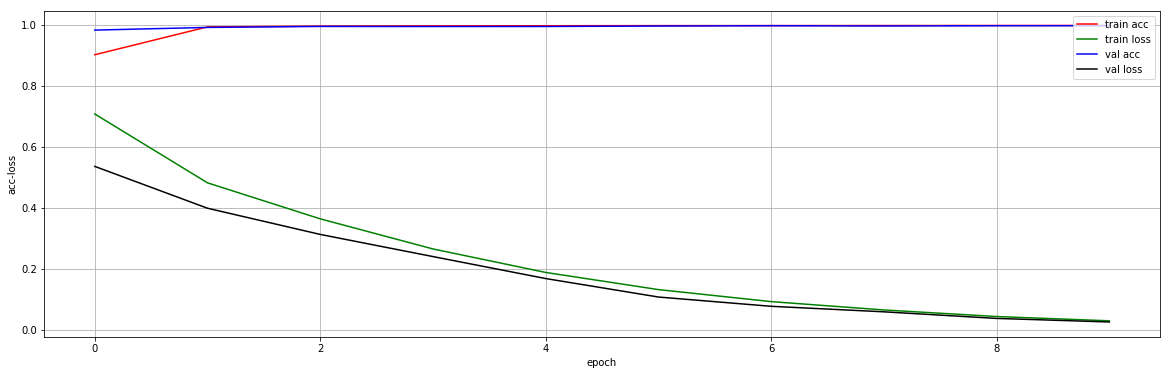

In [57]:
from keras.losses import categorical_crossentropy
# from keras_lookahead import Lookahead
from keras.callbacks import LearningRateScheduler
from keras.models import model_from_yaml

M = 3 # number of snapshots
nb_epoch = T = 180 # number of epochs
alpha_zero = 0.0001 # initial learning rate

np.random.seed(0)

epoch_print_callback = keras.callbacks.LambdaCallback(
    on_epoch_end =lambda epoch,logs: save_epoch(epoch,"unetplus") )

checkpoint = ModelCheckpoint(filepath='{}_deepsupervision_model_weights_{}.h5'.format('unetplus', time.strftime('%Y-%m-%d %X').split(" ")[0]),
                                 monitor= 'val_loss', mode='min', verbose=1,
                                 save_best_only='True',save_weights_only='True')

earlystop = EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=5
          )

reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1,
                             patience=3, min_lr=0.000001)

# reduce_lr = LearningRateScheduler(scheduler3)

#创建一个实例history
history = LossHistory()

callback_lists = [earlystop, checkpoint, history, reducelr, epoch_print_callback]

model = NestUnet(3)
# model = Attention_unet()

# yaml_string = model.to_yaml()
# model = model_from_yaml(yaml_string)

# input_length = len_ecg
# input_layer = Input((input_length, 1))
# output_layer = build_model(input_layer=input_layer,block="resnext",start_neurons=16, DropoutRatio=0.5, filter_size=32, nClasses=3)
# model = Model(input_layer, output_layer)

model.compile(loss=categorical_crossentropy,# ,#custom_loss,#  # bce_dice_loss, binary_crossentropy, categorical_crossentropy，mse
              optimizer=RAdam(0.0001),  # RAdam,'mse'，Lookahead(RAdam(lr=0.0001)),bce_dice_loss，focal_tversky
              metrics=['accuracy', auc, f1])  # mse、categorical_crossentropy

if deep_supervision:
    model.fit(x_train, [y_train,y_train,y_train, y_train],
          epochs=100, batch_size=64, verbose=2,
          callbacks= callback_lists
         )
else:
    model.fit(x_train, target_train,
          validation_split=0.1, 
          epochs=10, batch_size=64, verbose=2,
          callbacks= callback_lists
         )
history.loss_plot('epoch')

In [58]:
tf.__version__

'1.13.1'

In [87]:
# 保存模型
yaml_string = model.to_yaml()
fname_model = 'resnet_model.yaml'
with open(fname_model, "w") as f:
    f.write(yaml_string) 

In [35]:
# 保存权重
# fname_model_weigths = 'model_weights_{}.h5'.format(time.strftime('%Y-%m-%d %H-%M-%S'))
# model.save_weights(fname_model_weigths)

# 预测

In [36]:
# x_test = x_train
# y_test = y_train

In [100]:
#从yaml中读出模型
from keras.models import model_from_yaml
fname_model = 'model.yaml'
yaml_file = open(fname_model, 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)

# 加载模型权重
fname_model_weigths = 'unetplus_deepsupervision_model_weights_2020-10-12.h5'
model.load_weights(fname_model_weigths)

In [59]:
pred_test_all = model.predict(x_test)

In [60]:
pred_test = pred_test_all

In [61]:
pred_test.shape

(18468, 2000, 3)

In [62]:
# target_pred = pred_test
# target_pred[(target_pred>=0.5)]=1
# target_pred[(target_pred<0.5)]=0

target_pred = np.argmax(pred_test, axis = 2)   
y_pred = target_pred.reshape(-1,1)

In [81]:
33323981/1024

32542.9501953125

In [63]:
y_true = y_test.reshape(-1,1)
np.where(y_true==np.array([2]))

(array([    2532,     2533,     2534, ..., 33324331, 33324332, 33324333]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [64]:
from sklearn.metrics import confusion_matrix
import itertools
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[9.94674894e-01 2.76718126e-03 2.55792430e-03]
 [4.70904899e-01 5.28246441e-01 8.48659877e-04]
 [4.38374235e-01 1.59748855e-02 5.45650879e-01]]


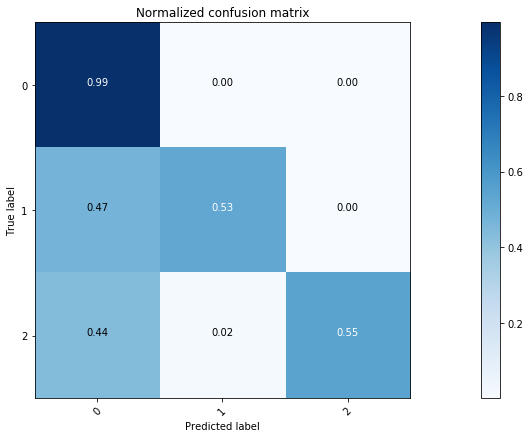

In [65]:
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=range(nClasses), normalize=True, title='Normalized confusion matrix')

In [66]:
ind = 32542  #17902 + 18168 # 8159

plt.figure(figsize=(15,5))
ax1, = plt.plot(x_test[ind],)
ax2, = plt.plot(y_test[ind],'r')       #红色是目标
ax3, = plt.plot(target_pred[ind],'g')  #绿色是预测
plt.legend([ax1, ax2, ax3], ['ecg', 'target label', 'predicted label'])
# plt.xlim(0,500)
plt.ylim(-1.5,3.5)
plt.show()

IndexError: index 32542 is out of bounds for axis 0 with size 18468

<Figure size 1080x360 with 0 Axes>

# 转化到Rloc

In [83]:
target_pred.shape

(36070, 1024)

In [84]:
target_pred.reshape(-1)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [85]:
x_test = np.expand_dims(ecg_data_split, axis=2)
pred_test = model.predict(x_test)
target_pred = np.argmax(pred_test, axis = 2)
y_pred = target_pred.reshape(-1,1)
# y_true = y_test.reshape(-1,1)

NameError: name 'ecg_data_split' is not defined

In [86]:
target_pred.shape

(36070, 1024)

In [87]:
y_pred = target_pred[:9166].reshape(-1)
# y_test = ecg_label_split

In [88]:
ind = int(s_ref[60]/len_seg)

plt.figure(figsize=(15,5))
ax1, = plt.plot(x_test[ind],)
ax2, = plt.plot(y_test[ind],'r')       #红色是目标
ax3, = plt.plot(target_pred[ind],'g')  #绿色是预测
plt.legend([ax1, ax2, ax3], ['ecg', 'target label', 'predicted label'])
# plt.xlim(0,500)
plt.ylim(-1.5,3.5)
plt.show()

IndexError: index 60 is out of bounds for axis 0 with size 0

In [89]:
s_count = 0
v_count = 0

s_results = []
v_results = []

for i in tqdm(range(0,len(y_pred))):
    if (y_pred[i]>1):
        v_count = v_count+1
    elif (y_pred[i]>0):
        s_count = s_count+1
    else:
        if (s_count>=200*0.1):#40
            ind = i- round(s_count*0.3)
            s_results.append(ind)
            
        if (v_count>=200*0.1):#40
            ind = i- round(v_count*0.3)
            v_results.append(ind)
            
        s_count=0
        v_count=0

# if (count>=200*0.1*0.5):#60
#     ind = len(y_pred)- round(count*0.5)
#     r_ans.append(ind)

100%|████████████████████████████████████████████████████████████████████| 9385984/9385984 [00:25<00:00, 370413.30it/s]


In [90]:
len(v_results)

972

In [91]:
s_ref = sio.loadmat('../TrainingSet/ref\\R08.mat')['ref']['S_ref'][0, 0].squeeze()
v_ref = sio.loadmat('../TrainingSet/ref\\R08.mat')['ref']['V_ref'][0, 0].squeeze()
#标签下采样
s_ref = (s_ref*CONST).astype(int)
v_ref = (v_ref*CONST).astype(int)

S_ref = (s_ref/CONST).astype(int)
V_ref = (v_ref/CONST).astype(int)

S_results = (np.array(s_results)/CONST).astype(int)
V_results = (np.array(v_results)/CONST).astype(int)

In [92]:
S_ref.shape,V_ref.shape,S_results.shape,V_results.shape

((0,), (2793,), (420,), (972,))

In [98]:
S1, S2 = CPSC2020_score([S_ref], [V_ref],[S_results],[V_results])

print ("S_score: {}".format(S1))
print ("V_score: {}".format(S2))

S_score: -420.0
V_score: -11320.0


In [68]:
def CPSC2020_challenge(ECG, fs):
    """   """
    # 数据下采样
    ecg_data = ECG[1::2]
    len_ecg = len(ecg_data)

    #数据预处理
    ecg_data = med_filt_1d(ecg_data)
    ##ecg_data = butter_bandpass_forward_backward_filter(ecg_data, 0.5, 35, FS, order=5)

    ecg_data_split = []

    for i in tqdm(range(int(ecg_data.shape[0]/len_seg))):
        ecg_data_split.append(ecg_data[i*len_seg:(i+1)*len_seg].tolist())
    ecg_data_split = np.array(ecg_data_split)

    ecg_data_split = getSigArr(ecg_data_split.T).T

    ecg_data_split = np.expand_dims(ecg_data_split, axis=2)
    
#     from keras.models import model_from_yaml
#     fname_model = 'resnet_model.yaml'
#     yaml_file = open(fname_model, 'r')
#     loaded_model_yaml = yaml_file.read()
#     yaml_file.close()
#     model = model_from_yaml(loaded_model_yaml)

#     # 加载模型权重
#     fname_model_weigths = 'unetplus_deepsupervision_model_weights_2020-10-15.h5'
#     model.load_weights(fname_model_weigths)
    
    pred_test = model.predict(ecg_data_split)

    target_pred = np.argmax(pred_test, axis = 2)  
    
    y_pred = target_pred.reshape(-1)
    
    s_count = 0
    v_count = 0

    s_results = []
    v_results = []

    for i in tqdm(range(0,len(y_pred))):
        if (y_pred[i]>1):
            v_count = v_count+1
        elif (y_pred[i]>0):
            s_count = s_count+1
        else:
            if (s_count>=200*0.1):#40
                ind = i- round(s_count*0.3)
                s_results.append(ind)

            if (v_count>=200*0.1):#40
                ind = i- round(v_count*0.3)
                v_results.append(ind)

            s_count=0
            v_count=0
            
    S_pos = (np.array(s_results)/CONST).astype(int)
    V_pos = (np.array(v_results)/CONST).astype(int)
    
    return S_pos, V_pos


In [72]:
FS = 400
THR = 0.15
DATA_PATH = '../TrainingSet/data/'
REF_PATH = '../TrainingSet/ref/'
import glob
import numpy as np
import os
import scipy.io as sio

def load_ans():
    """
    Function for loading the detection results and references
    Input:

    Ouput:
        S_refs: position references for S
        V_refs: position references for V
        S_results: position results for S
        V_results: position results for V
    """
    data_files = glob.glob(DATA_PATH + '*.mat')
    ref_files = glob.glob(REF_PATH + '*.mat')
    
    data_files.sort()
    ref_files.sort()
    
    data_files = data_files[7:9]
    ref_files  = ref_files[7:9]
    
    S_refs = []
    V_refs = []
    S_results = []
    V_results = []
    for i, data_file in enumerate(data_files[:]):
        print(data_file,ref_files[i])
        # load ecg file
        ecg_data = sio.loadmat(data_file)['ecg'].squeeze()
        # load answers
        s_ref = sio.loadmat(ref_files[i])['ref']['S_ref'][0, 0].squeeze()
        v_ref = sio.loadmat(ref_files[i])['ref']['V_ref'][0, 0].squeeze().reshape(-1)
        # process ecg and conduct event detection using your algorithm
        s_pos, v_pos = CPSC2020_challenge(ecg_data, FS)
        S_refs.append(s_ref)
        V_refs.append(v_ref)
        S_results.append(s_pos)
        V_results.append(v_pos)

    return S_refs, V_refs, S_results, V_results

S_refs, V_refs, S_results, V_results = load_ans()

../TrainingSet/data/A08.mat ../TrainingSet/ref/R08.mat


100%|██████████| 18332000/18332000 [00:08<00:00, 2241748.57it/s]


../TrainingSet/data/A09.mat ../TrainingSet/ref/R09.mat


100%|██████████| 18604000/18604000 [00:09<00:00, 1998415.00it/s]


In [73]:
def CPSC2020_score(S_refs, V_refs, S_results, V_results):
    """
    Score Function
    Input:
        S_refs, V_refs, S_results, V_results
    Output:
        Score1: score for S
        Score2: score for V
    """
    s_score = np.zeros([len(S_refs), ])
    v_score = np.zeros([len(S_refs), ])
    ## Scoring ##
    for i, s_ref in enumerate(S_refs):
        v_ref = V_refs[i]
        s_pos = S_results[i]
        v_pos = V_results[i]
        s_tp = 0
        s_fp = 0
        s_fn = 0
        v_tp = 0
        v_fp = 0
        v_fn = 0
        if s_ref.size == 0:
            s_fp = len(s_pos)
        else:
            for m, ans in enumerate(s_ref):
                s_pos_cand = np.where(abs(s_pos-ans) <= THR*FS)[0]
                if s_pos_cand.size == 0:
                    s_fn += 1
                else:
                    s_tp += 1
                    s_fp += len(s_pos_cand) - 1
        if v_ref.size == 0:
            v_fp = len(v_pos)
        else:
            for m, ans in enumerate(v_ref):
                v_pos_cand = np.where(abs(v_pos-ans) <= THR*FS)[0]
                if v_pos_cand.size == 0:
                    v_fn += 1
                else:
                    v_tp += 1
                    v_fp += len(v_pos_cand) - 1
        # calculate the score
        s_score[i] = s_fp * (-1) + s_fn * (-5)
        v_score[i] = v_fp * (-1) + v_fn * (-5)
    Score1 = np.sum(s_score)
    Score2 = np.sum(v_score)

    return Score1, Score2

In [74]:
index = 11
S1, S2 = CPSC2020_score(S_refs[:index], V_refs[:index], S_results[:index], V_results[:index])

print ("S_score: {}".format(S1))
print ("V_score: {}".format(S2))

S_score: -3380.0
V_score: -8196.0
